In [1]:
import yaml
import pprint
from Dimensionner import Dimensionner
import matplotlib.pyplot as plt


def load_config(file_name):
    if file_name:
        with open(file_name, 'r') as file:
            config = yaml.safe_load(file)
    return config


In [2]:
config = load_config("init_config.yml")

In [3]:
pprint.pprint(config)

{'DMD': {'micromirror size': 5.4,
         'number of micromirrors across dispersion': 500,
         'number of micromirrors along dispersion': 1500},
 'camera': {'number of pixels across dispersion': 37,
            'number of pixels along dispersion': 55,
            'pixel size': 200},
 'infos': {'results directory': './dimensionning_results',
           'system name': 'HYACAMEO'},
 'spectral range': {'wavelength center': 550,
                    'wavelength max': 750,
                    'wavelength min': 450},
 'system architecture': {'dispersive element 1': {'A': 60,
                                                  'G': 160,
                                                  'delta alpha c': 0,
                                                  'delta beta c': 0,
                                                  'm': 1,
                                                  'type': 'prism'},
                         'focal lens 1': 165000,
                         'focal lens 2': 16500

In [4]:
spectral_samples = 10
config["spectral_samples"] = spectral_samples

In [5]:
dimensionner = Dimensionner(config)

In [6]:
list_X_dmd, list_Y_dmd, list_wavelengths = dimensionner.propagate()

0.6771566685400001


In [7]:
X_cam = dimensionner.X_cam
Y_cam = dimensionner.Y_cam

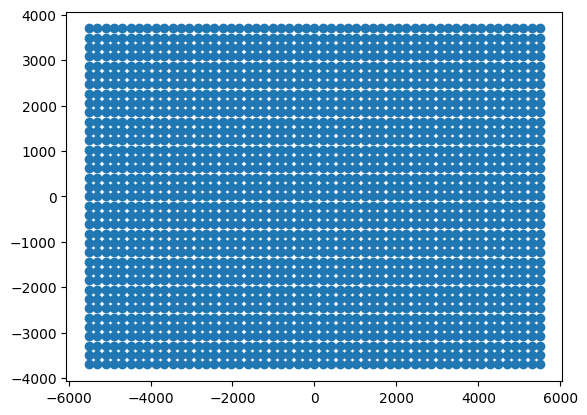

In [8]:
plt.scatter(X_cam,Y_cam)

In [9]:
from utils.functions_retropropagating import *

In [10]:
import jax.numpy as np
from jax import grad, jacfwd






In [11]:
F = dimensionner.config["system architecture"]["focal lens 1"]
A = dimensionner.config["system architecture"]["dispersive element 1"]["A"]
alpha_c = dimensionner.alpha_c
delta_alpha_c = dimensionner.config["system architecture"]["dispersive element 1"]["delta alpha c"]
delta_beta_c = dimensionner.config["system architecture"]["dispersive element 1"]["delta beta c"]

In [12]:
propagate_through_arm_scalar(X_cam[0,0],Y_cam[0,0],1.518,A,F,alpha_c, delta_alpha_c,delta_beta_c)

(3, 1) (3, 1)


(array([91946.71135809]), array([4233.35003155]))

In [13]:
jacobian_propagate = jacfwd(dimensionner.propagate_through_arm_scalar_no_params)

X_cam_float = np.float32(X_cam[0,0])
Y_cam_float = np.float32(Y_cam[0,0])
A_float = np.float32(A)
F_float = np.float32(F)
alpha_c_float = np.float32(alpha_c)
delta_alpha_c_float = np.float32(delta_alpha_c)
delta_beta_c_float = np.float32(delta_beta_c)

jacobian_at_x0 = np.array(jacobian_propagate((X_cam_float,Y_cam_float,1.518)))[:,:,0]

print(jacobian_at_x0)


# Use the Jacobian matrix to approximate the function's values at a new point
X_cam_new = X_cam_float + 50
Y_cam_new = Y_cam_float - 50
n_new = 1.518 -0.001

x0 = np.array([X_cam_float,Y_cam_float,1.518])
x_new = np.array([X_cam_new,Y_cam_new,n_new])

f_x0 = np.array(dimensionner.propagate_through_arm_scalar_no_params(x0))
delta_x = x_new - x0

print(jacobian_at_x0.shape)
print(np.dot(jacobian_at_x0, delta_x).shape)


approx_f_x_new = f_x0[:,0] + np.dot(jacobian_at_x0, delta_x)


print(approx_f_x_new)

f_x0_delta = np.array(dimensionner.propagate_through_arm_scalar_no_params(x_new))
print(f_x0_delta)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(3, 1) (3, 1)
[[-9.4327980e-01  2.8800765e-02 -2.4703403e+05]
 [ 5.2754469e-05 -9.9996269e-01 -1.8171890e+02]]
(3, 1) (3, 1)
(2, 3)
(2,)
[5617.0044 3750.1226]
(3, 1) (3, 1)
[[5616.8896]
 [3750.128 ]]


In [14]:
jacobian_propagate2 = jacfwd(dimensionner.propagate_through_arm_vector_no_params)

X_cam_float = np.float32(X_cam).flatten()
Y_cam_float = np.float32(Y_cam).flatten()
n_array_float = np.full(X_cam.shape,sellmeier(580)).flatten()
A_float = np.float32(A)
F_float = np.float32(F)
alpha_c_float = np.float32(alpha_c)
delta_alpha_c_float = np.float32(delta_alpha_c)
delta_beta_c_float = np.float32(delta_beta_c)

jacobian_at_x0 = np.array(jacobian_propagate2((X_cam_float,Y_cam_float,n_array_float)))[:,:,0]

(3, 1, 2035) (3, 2035)


In [15]:
print(jacobian_at_x0.shape)

(2, 3, 2035)


In [16]:
# Use the Jacobian matrix to approximate the function's values at a new point
X_cam_new = X_cam_float + 50
Y_cam_new = Y_cam_float - 50
n_new = n_array_float -0.001

x0 = np.array([X_cam_float,Y_cam_float,n_array_float])
x_new = np.array([X_cam_new,Y_cam_new,n_new])

f_x0 = np.array(dimensionner.propagate_through_arm_vector_no_params(x0))
delta_x = x_new - x0


print(jacobian_at_x0.shape,delta_x.shape)
# Add an extra dimension to delta_x
delta_x = np.expand_dims(delta_x, axis=1)  # shape is now (3, 1, 2035)

print(delta_x.shape,jacobian_at_x0.shape)
# Perform the dot product
approx_f_x_new = f_x0 + np.einsum('ijk,jik->ik', jacobian_at_x0, delta_x)

f_x0_delta = np.array(dimensionner.propagate_through_arm_vector_no_params(x_new))
print(f_x0_delta)

(3, 1, 2035) (3, 2035)
(2, 3, 2035) (3, 2035)
(3, 1, 2035) (2, 3, 2035)
(3, 1, 2035) (3, 2035)
[[ 5833.4854  5641.3955  5448.9277 ... -4716.241  -4931.089  -5146.46  ]
 [ 3750.2983  3750.2961  3750.2937 ... -3649.718  -3649.7144 -3649.711 ]]


SyntaxError: invalid syntax (2956996683.py, line 1)